<a href="https://www.kaggle.com/code/abhineetsahay/cat-dog-classifier?scriptVersionId=300171366" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
        print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/datasets
/kaggle/input/datasets/abhineetsahay
/kaggle/input/datasets/abhineetsahay/testmine
/kaggle/input/cat-and-dog
/kaggle/input/cat-and-dog/test_set
/kaggle/input/cat-and-dog/test_set/test_set
/kaggle/input/cat-and-dog/test_set/test_set/dogs
/kaggle/input/cat-and-dog/test_set/test_set/cats
/kaggle/input/cat-and-dog/training_set
/kaggle/input/cat-and-dog/training_set/training_set
/kaggle/input/cat-and-dog/training_set/training_set/dogs
/kaggle/input/cat-and-dog/training_set/training_set/cats


In [2]:
PATH="/kaggle/input/cat-and-dog/training_set/training_set"

In [3]:

input_path = []
label = []

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for class_name in os.listdir(PATH):
    class_folder = os.path.join(PATH, class_name)
    
    for file in os.listdir(class_folder):
        # Skip non-image files (VERY IMPORTANT)
        if not file.lower().endswith(valid_extensions):
            continue
        
        full_path = os.path.join(class_folder, file)
        
        if class_name.lower() == 'dogs':
            label.append(0)
        else:
            label.append(1)
            
        input_path.append(full_path)

In [4]:
print(input_path[0],label[0])

/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.3443.jpg 0


In [5]:
df=pd.DataFrame()
df["images_path"]=input_path
df['label']=label

In [6]:
df.head()

,images_path,label
0,/kaggle/input/cat-and-dog/training_set/trainin...,0
1,/kaggle/input/cat-and-dog/training_set/trainin...,0
2,/kaggle/input/cat-and-dog/training_set/trainin...,0
3,/kaggle/input/cat-and-dog/training_set/trainin...,0
4,/kaggle/input/cat-and-dog/training_set/trainin...,0


In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [10]:
from torch.utils.data import Dataset
from PIL import Image

class SimpleCatDogDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
dataset = SimpleCatDogDataset(input_path, label, transform=transform)

## CNN model

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  
            nn.Linear(128, 2) 
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [13]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

## Training

In [15]:
epochs = 7

for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Print every 10 batches (more visible)
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f}")
    
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = (correct / total) * 100
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Average Loss: {epoch_loss:.4f}")
    print(f"Training Accuracy: {epoch_acc:.2f}%")

print("\nTraining Finished 🎯")


===== Epoch 1/7 =====
Batch [10/251] Loss: 0.6973
Batch [20/251] Loss: 0.6779
Batch [30/251] Loss: 0.6354
Batch [40/251] Loss: 0.6880
Batch [50/251] Loss: 0.6706
Batch [60/251] Loss: 0.6920
Batch [70/251] Loss: 0.6918
Batch [80/251] Loss: 0.6987
Batch [90/251] Loss: 0.6964
Batch [100/251] Loss: 0.6918
Batch [110/251] Loss: 0.7908
Batch [120/251] Loss: 0.6676
Batch [130/251] Loss: 0.7194
Batch [140/251] Loss: 0.7156
Batch [150/251] Loss: 0.6308
Batch [160/251] Loss: 0.7431
Batch [170/251] Loss: 0.6869
Batch [180/251] Loss: 0.6996
Batch [190/251] Loss: 0.7333
Batch [200/251] Loss: 0.7269
Batch [210/251] Loss: 0.5968
Batch [220/251] Loss: 0.6807
Batch [230/251] Loss: 0.6501
Batch [240/251] Loss: 0.6011
Batch [250/251] Loss: 0.7253

Epoch 1 Summary:
Average Loss: 0.6832
Training Accuracy: 56.23%

===== Epoch 2/7 =====
Batch [10/251] Loss: 0.6650
Batch [20/251] Loss: 0.6655
Batch [30/251] Loss: 0.6634
Batch [40/251] Loss: 0.6533
Batch [50/251] Loss: 0.6046
Batch [60/251] Loss: 0.6746
Batch

In [16]:
model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_acc = (val_correct / val_total) * 100
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 79.31%


In [17]:
Test_PATH="/kaggle/input/cat-and-dog/test_set/test_set"

In [18]:
import os

test_input_path = []
test_labels = []

valid_extensions = ('.jpg', '.jpeg', '.png')

for class_name in os.listdir(Test_PATH):
    class_folder = os.path.join(Test_PATH, class_name)
    
    for file in os.listdir(class_folder):
        if not file.lower().endswith(valid_extensions):
            continue
            
        img_path = os.path.join(class_folder, file)
        test_input_path.append(img_path)
        
        # Label mapping (same as training)
        if class_name.lower() == 'dogs':
            test_labels.append(0)
        else:
            test_labels.append(1)

print("Total test images:", len(test_input_path))

Total test images: 2023


In [19]:
test_dataset = SimpleCatDogDataset(
    test_input_path,
    test_labels,
    transform=transform
)

In [20]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False  
)

## Test Results

In [21]:
model.eval()

correct = 0
total = 0
test_loss = 0

with torch.no_grad(): 
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
avg_loss = test_loss / len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}% 🎯")


===== TEST RESULTS =====
Test Loss: 0.4756
Test Accuracy: 77.51% 🎯


In [22]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Linear-10                  [-1, 128]       2,097,280
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 2]             258
Total params: 2,121,122
Trainable param

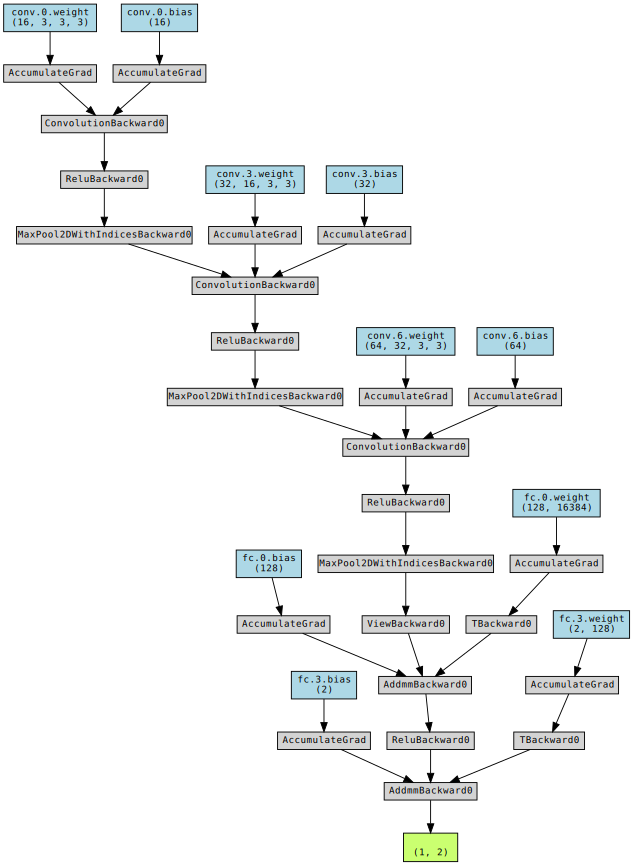

In [23]:
!pip install torchviz

from torchviz import make_dot
import torch

x = torch.randn(1, 3, 128, 128).to(device)

y = model(x)

make_dot(y, params=dict(model.named_parameters()))